## Interpolação de Dados: Análise do perfil de sobreviventes do Titanic


In [22]:
# Libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
from scipy.interpolate import PchipInterpolator
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Firstly, checking out the training dataset
os.listdir('databases/titanic')

training_dataset = pd.read_csv('databases/titanic/train.csv')

# Printing column lengths
print(f'Training dataset shape: {training_dataset.shape}')

training_dataset.head()

Training dataset shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Colunas: 

ID_Passageiro; 

Se_Sobreviveu (bool); 

Classe_ticket (1, 2, 3); 

Nome; 

Sexo; 

Idade; 

N° de irmãos/conjuges a bordo; 

N° de pais/crianças a bordo; 

N° Ticket; 

Tarifa de passageiro; 

N° dos aposentos;

Porto de embarque (C = Cherbourg, Q = Queenstown, S = Southampton);

### Checando Dados Faltosos

In [24]:
# Defining function to check for missing data in a dataframe
# Shows absolute number and relative % to total
def missing_data_checker(dataframe):
    missing_values_num = dataframe.isnull().sum()
    missing_values_percentage = 100 * missing_values_num / len(dataframe)

    # Make a table so as to show organized values
    missing_values_table = pd.concat([missing_values_num, missing_values_percentage], axis=1)

    # Rename collumns
    missing_values_table_cols_renamed = missing_values_table.rename(columns = {0 : 'Valores Faltosos', 1 : '% de valores faltosos'})

    # Sort table by descending % of missing data, isolating only where '% of total values' is not 0
    missing_values_table_cols_renamed = missing_values_table_cols_renamed[
        missing_values_table_cols_renamed.iloc[:,1] != 0].sort_values(
        '% de valores faltosos', ascending=False).round(1)

    # Printing standart info
    print(f'Dataframe possui {str(dataframe.shape[1])} colunas')
    print(f'Há {str(missing_values_table_cols_renamed.shape[0])} colunas com valores faltosos')

    return missing_values_table_cols_renamed

# Now checking it out
training_ds_missing = missing_data_checker(training_dataset)
training_ds_missing

Dataframe possui 12 colunas
Há 3 colunas com valores faltosos


,Valores Faltosos,% de valores faltosos
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


<Axes: >

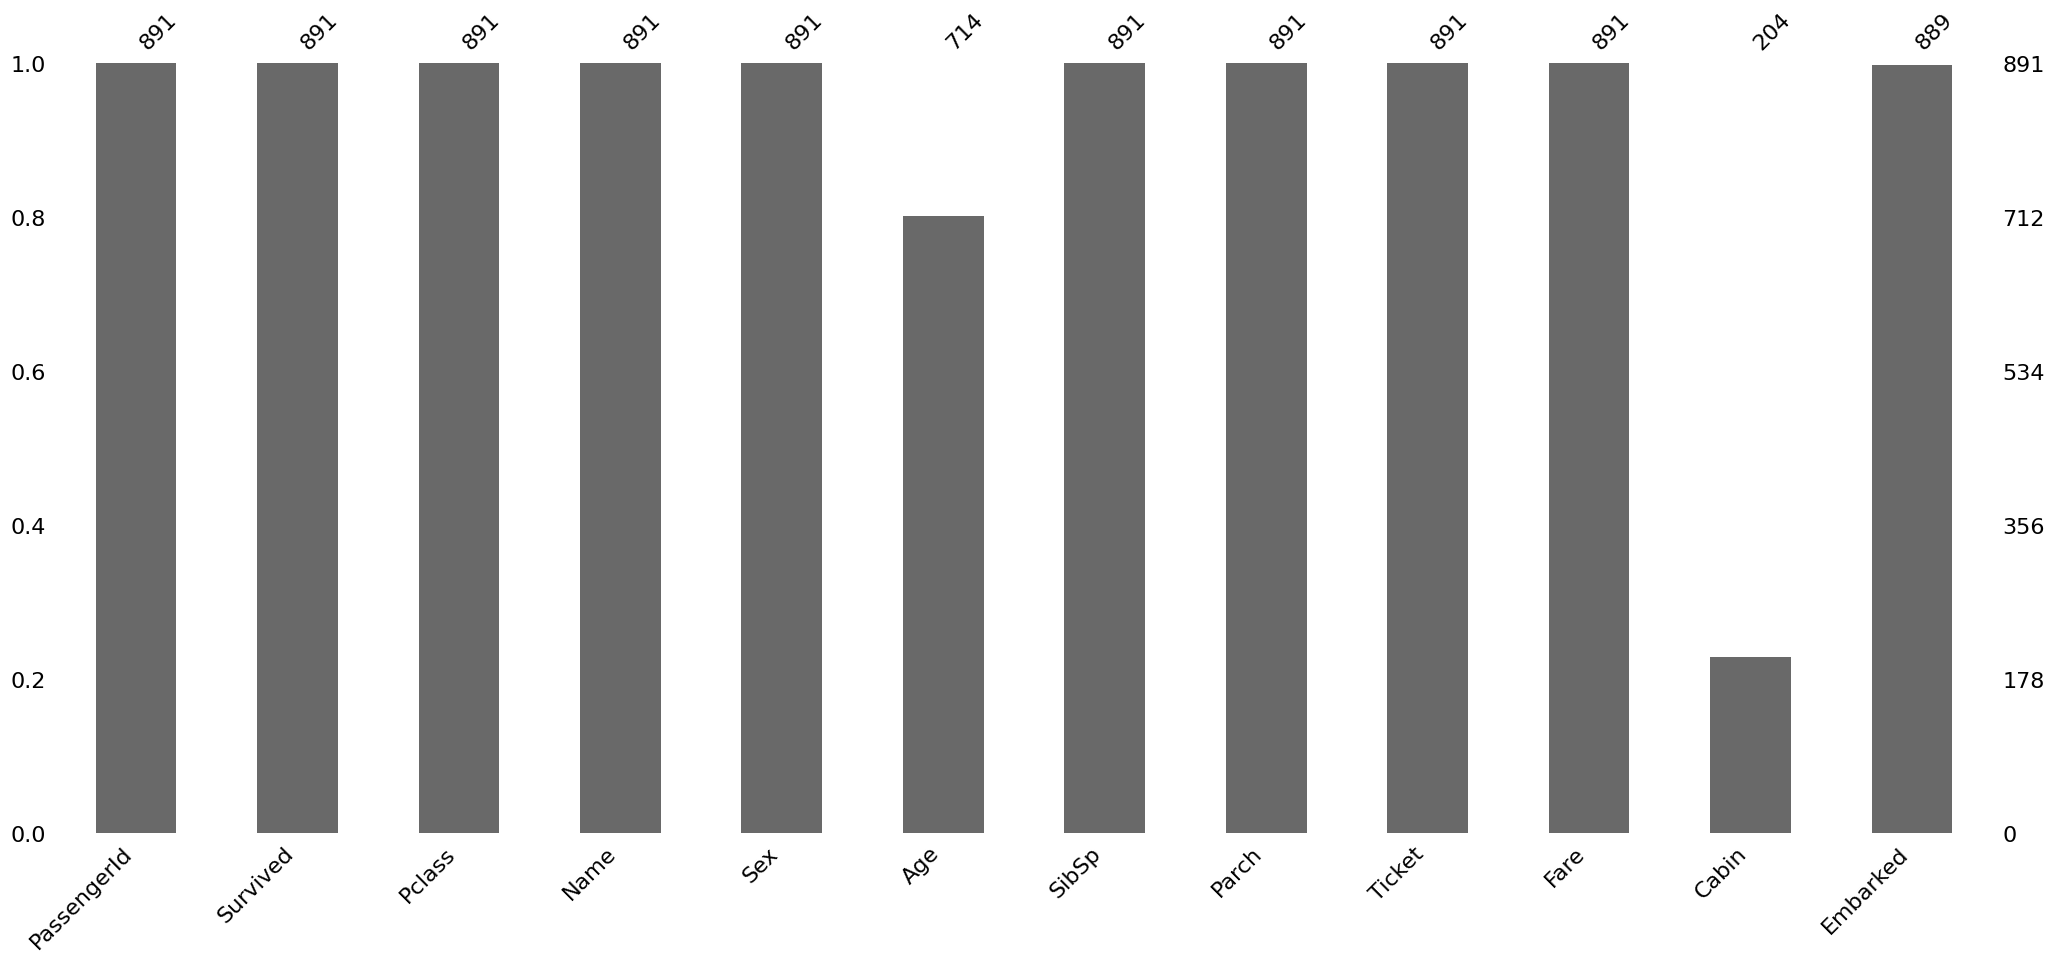

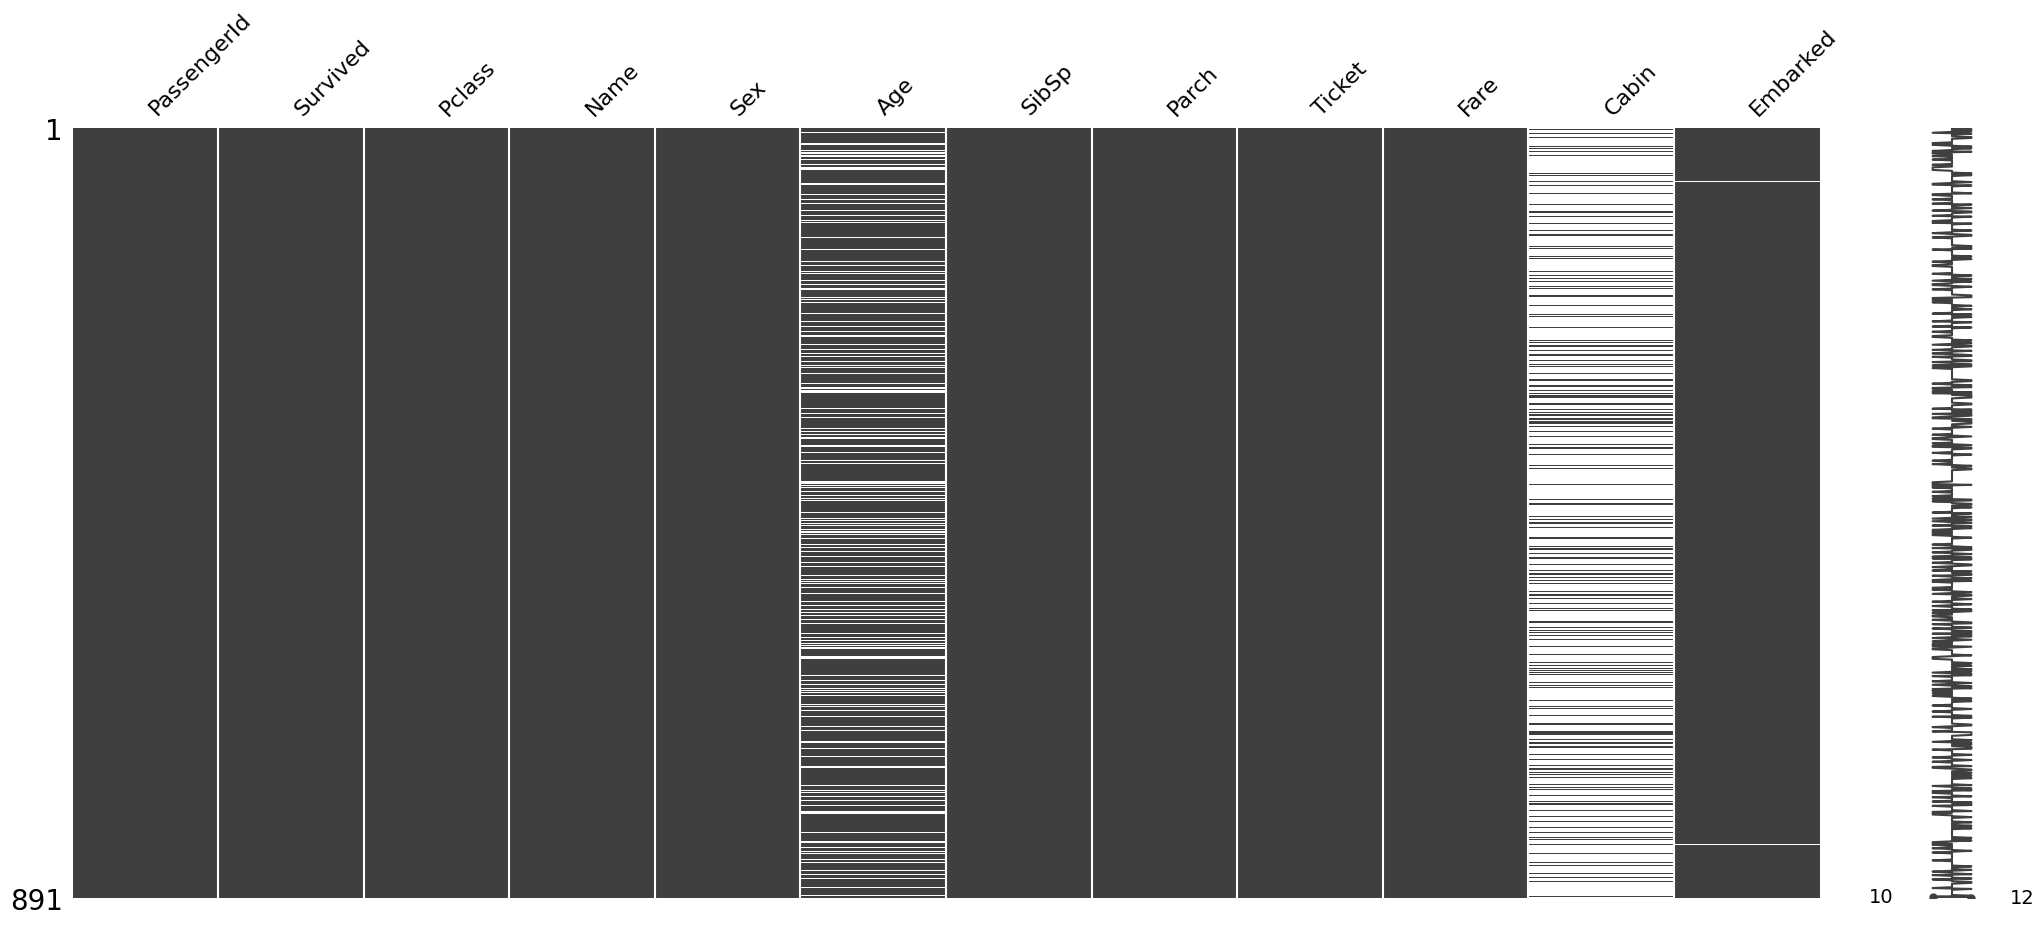

In [25]:
# Checking out missing data per collumn and sparsity of faulty collumns
msno.bar(training_dataset)
msno.matrix(training_dataset)

#### Interpolação de Hermite
É um tipo de interpolação polinomial que garante que tanto os valores nos pontos sejam correspondentes, quanto que a entre os dois pontos usados seja mais suave, correspondente as sua posições relativas um ao outro.

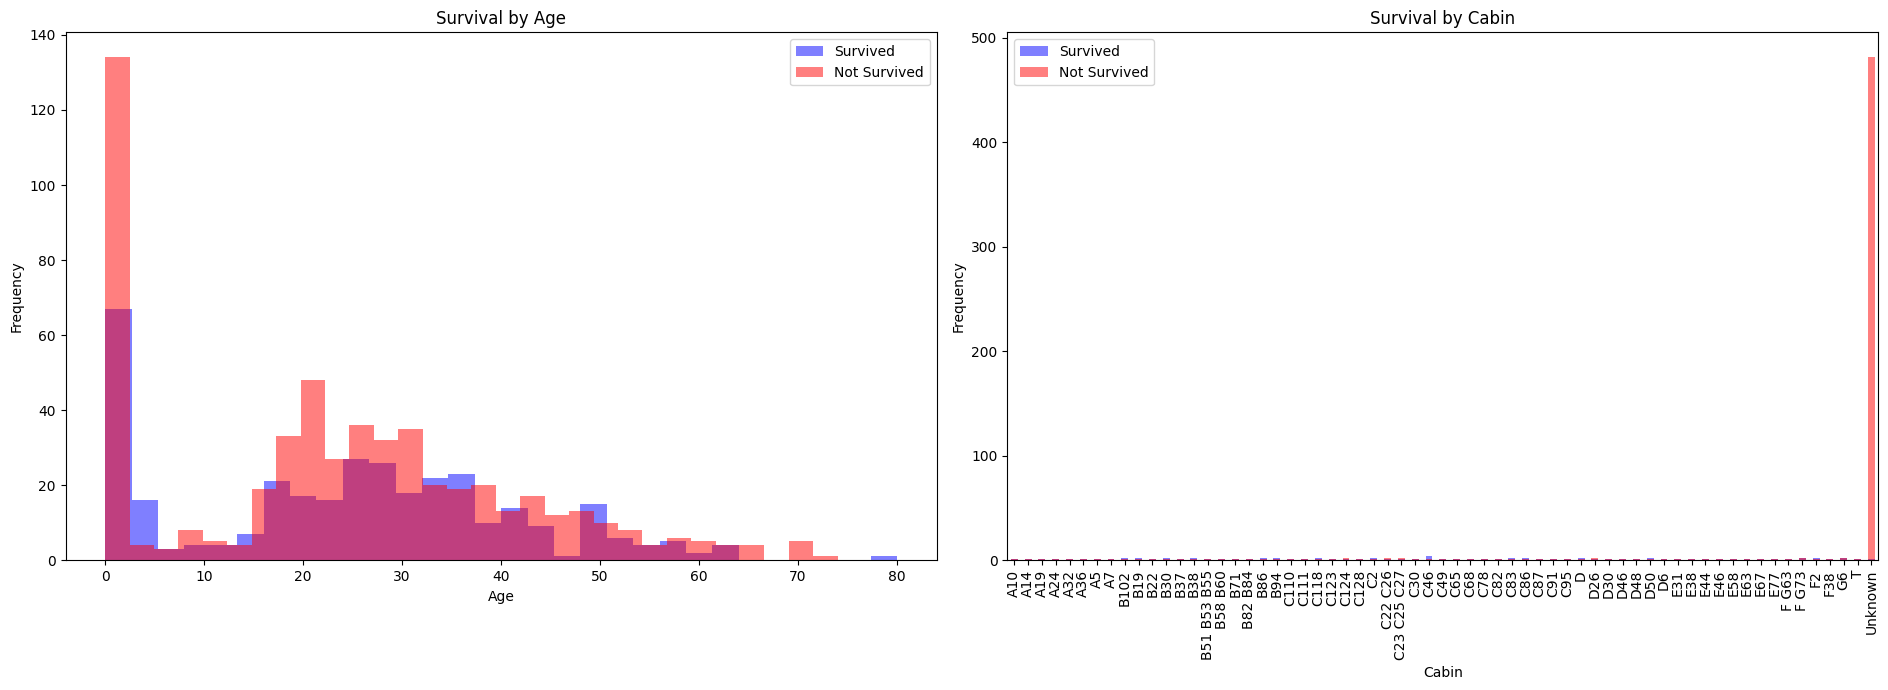

In [35]:
# Load the training dataset
training_dataset = pd.read_csv('databases/titanic/train.csv')

# Fill missing values in 'Age' with 0 and 'Cabin' with 'Unknown' just for this one
training_dataset['Age'] = training_dataset['Age'].fillna(0)
training_dataset['Cabin'] = training_dataset['Cabin'].fillna('Unknown')

# Plot 'Survival' vs 'Age'
plt.figure(figsize=(19, 7))
plt.subplot(1, 2, 1)
training_dataset[training_dataset['Survived'] == 1]['Age'].plot(kind='hist', bins=30, alpha=0.5, color='blue', label='Survived')
training_dataset[training_dataset['Survived'] == 0]['Age'].plot(kind='hist', bins=30, alpha=0.5, color='red', label='Not Survived')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Survival by Age')
plt.legend()

# Plot 'Survival' vs 'Cabin'
plt.subplot(1, 2, 2)
training_dataset[training_dataset['Survived'] == 1]['Cabin'].value_counts().sort_index().plot(kind='bar', alpha=0.5, color='blue', label='Survived')
training_dataset[training_dataset['Survived'] == 0]['Cabin'].value_counts().sort_index().plot(kind='bar', alpha=0.5, color='red', label='Not Survived')
plt.xlabel('Cabin')
plt.ylabel('Frequency')
plt.title('Survival by Cabin')
plt.legend()

plt.tight_layout()
plt.show()

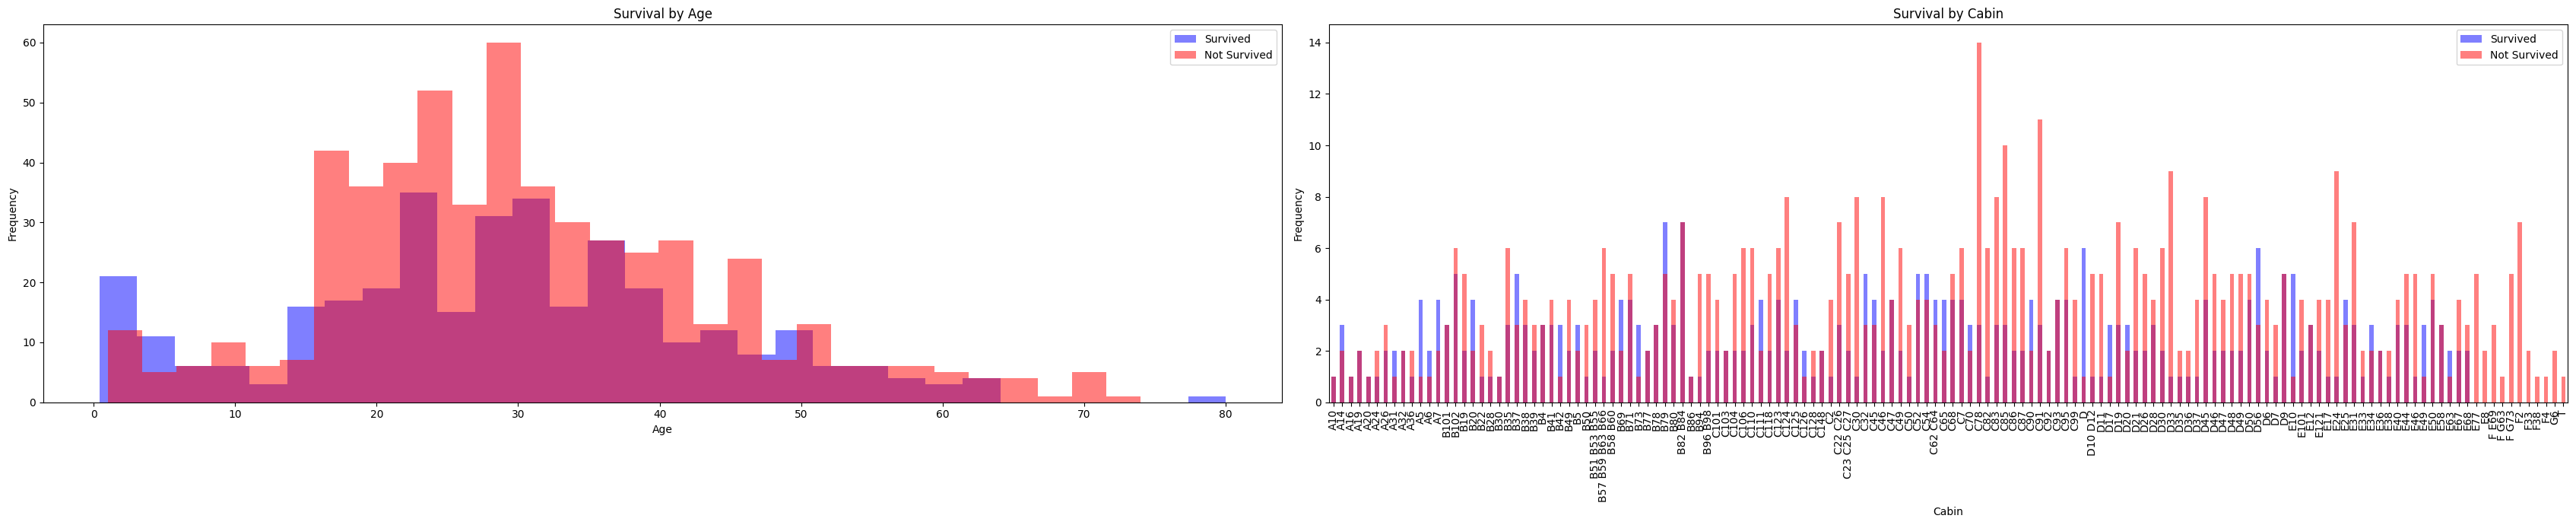

In [ ]:
# Load the training dataset
training_dataset = pd.read_csv('databases/titanic/train.csv')

# Fill missing values in 'Cabin' with 'Unknown'
training_dataset['Cabin'] = training_dataset['Cabin'].fillna('Unknown')

# Label encode the 'Cabin' column
label_encoder = LabelEncoder()
training_dataset['Cabin'] = label_encoder.fit_transform(training_dataset['Cabin'])

# Interpolate missing values in 'Age' using PchipInterpolator
age_not_null = training_dataset[training_dataset['Age'].notnull()]
age_null = training_dataset[training_dataset['Age'].isnull()]

# Create the interpolator for 'Age'
age_interpolator = PchipInterpolator(age_not_null.index, age_not_null['Age'])

# Interpolate missing 'Age' values
training_dataset.loc[training_dataset['Age'].isnull(), 'Age'] = age_interpolator(age_null.index)

# Interpolate missing values in 'Cabin' using PchipInterpolator
cabin_not_null = training_dataset[training_dataset['Cabin'] != label_encoder.transform(['Unknown'])[0]]
cabin_null = training_dataset[training_dataset['Cabin'] == label_encoder.transform(['Unknown'])[0]]

# Create the interpolator for 'Cabin'
cabin_interpolator = PchipInterpolator(cabin_not_null.index, cabin_not_null['Cabin'])

# Interpolate missing 'Cabin' values and cast to int cause pandas
training_dataset.loc[training_dataset['Cabin'] == label_encoder.transform(['Unknown'])[0], 'Cabin'] = cabin_interpolator(
                                                                                                        cabin_null.index).astype(int)

# Undo 'Cabin' col encoding
training_dataset['Cabin'] = label_encoder.inverse_transform(training_dataset['Cabin'])

# Plotting 'Survival' vs 'Age'
plt.figure(figsize=(34, 7))
plt.subplot(1, 2, 1)
training_dataset[training_dataset['Survived'] == 1]['Age'].plot(kind='hist', bins=30, alpha=0.5, color='blue', label='Survived')
training_dataset[training_dataset['Survived'] == 0]['Age'].plot(kind='hist', bins=30, alpha=0.5, color='red', label='Not Survived')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Survival by Age')
plt.legend()

# Plot 'Survival' vs 'Cabin'
plt.subplot(1, 2, 2)
training_dataset[training_dataset['Survived'] == 1]['Cabin'].value_counts().sort_index().plot(kind='bar', alpha=0.5, color='blue', label='Survived')
training_dataset[training_dataset['Survived'] == 0]['Cabin'].value_counts().sort_index().plot(kind='bar', alpha=0.5, color='red', label='Not Survived')
plt.xlabel('Cabin')
plt.ylabel('Frequency')
plt.title('Survival by Cabin')
plt.legend()

plt.tight_layout()
plt.show()

##